# <a id="top"></a>Performance of intersecting shapes with modelgrids using different spatial queries

_Note: This feature requires the shapely and descartes packages (which are not a FloPy dependency) so must be installed by the user._

This notebook studies the performance of intersections using different types of spatial queries.

### Table of Contents
- [Benchmarking](#benchmarking)

Import some stuff

In [1]:
import sys
import os
import platform
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
# import pygeos

sys.path.insert(1, "../..")

# run installed version of flopy or add local path
try:
    1/0
#     import flopy
#     import flopy.discretization as fgrid
#     import flopy.plot as fplot
#     from flopy.utils.triangle import Triangle as Triangle
#     from flopy.utils.gridintersect import GridIntersect
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    import flopy.discretization as fgrid
    import flopy.plot as fplot
    from flopy.utils.triangle import Triangle as Triangle
    from flopy.utils.gridintersect import GridIntersect

import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon
from shapely.strtree import STRtree    

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]
numpy version: 1.21.2
matplotlib version: 3.5.1
flopy version: 3.3.5


## <a id="benchmarking"></a>[Benchmarking](#top)


- List of shapes:
  - Points
    - 10 points on a quarter of the grid
    - 100 points all over the grid
  - LineString
    - Half-diagonal (diagonal covering one quarter of the grid)
    - Straight line (vertical line)
  - Polygon
    - Quarter grid (rectangle covering one quarter of the grid)
    - Long thin rectangle (height grid x width 1 m)
- List of grid sizes:
  - 10x10
  - 50x50
  - 100x100
  - 500x500
  - 1000x1000
    
- List of methods:
  - **STRtree**: Shapely STRtree implementation (this was implemented in the original GridIntersect)
  - **Rtree**: From the RTree package, implemented because [this post on GIS StackExchange](https://gis.stackexchange.com/questions/353619/shapely-with-rtree-versus-strtree) suggested it might be faster
  - **Filter**: Using `shapely.prepared.prep()` to prepare a polygon for a fast batch operations for intersects
  - **Structured**: taking advantage of knowing the grid is structured to accelerate intersections (this was already implemented in the original GridIntersect)

Helper function for obtaining a structured grid of 1000x1000 m with `nrnc` rows and columns:

In [2]:
def get_structured_grid(nrnc):
    delc = 1000/nrnc * np.ones(nrnc, dtype=float)
    delr = 1000/nrnc * np.ones(nrnc, dtype=float)
    sgr = fgrid.StructuredGrid(delc, delr, top=None, botm=None)
    return sgr

Define shapes to test intersection performance

In [3]:
np.random.seed(10)
shapes = [
    MultiPoint(np.random.random((10, 2)) * 500), 
    MultiPoint(np.random.random((100, 2)) * 1000),
    LineString([(0, 0), (500, 500)]),
    LineString([(751, 0), (751, 1000)]),
    Polygon([(0, 0), (0, 500), (500, 500), (500, 0), (0, 0)]),
    Polygon([(1, 1), (1, 1000), (2, 1000), (2, 1), (1, 1)])
]

Set gridsizes to test intersection performance

In [4]:
gridsizes = [10, 50, 100, 200, 500]

Name each of the cases

In [5]:
cases = [
    "Building Tree", 
    "Point:10", 
    "Point:100", 
    "Linestring:Halfdiag", 
    "Linestring:Straight", 
    "Polygon:Quarter", 
    "Polygon:Longthin"]

### STRtree

In [6]:
method = "vertex"
rtree = True

strtree_df = pd.DataFrame(index=cases, columns=["{0}x{0}".format(s) for s in gridsizes])

for nrnc in gridsizes:
    print("-"*10 + "{0}x{0}".format(nrnc) + "-"*10)
    sgr = get_structured_grid(nrnc)
    t = %timeit -o -r 1 -n 1 GridIntersect(sgr, method="vertex", rtree=rtree)
    strtree_df.loc["Building Tree", "{0}x{0}".format(nrnc)] = t.average
    
    ix = GridIntersect(sgr, method=method, rtree=rtree)
    for c, shp in zip(cases[1:], shapes):
        if c.startswith("Point"):
            t = %timeit -o -r 1 -n 1 ix.intersect(shp, sort_by_cellid=False)
        elif c.startswith("Linestring"):
            t = %timeit -o -r 1 -n 1 ix.intersect(shp, sort_by_cellid=False)
        elif c.startswith("Polygon"):
            t = %timeit -o -r 1 -n 1 ix.intersect(shp, sort_by_cellid=False)
        
        strtree_df.loc[c, "{0}x{0}".format(nrnc)] = t.average

----------10x10----------
6.08 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.51 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
13.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.02 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
11.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
----------50x50----------
59.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)
/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


5.43 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
45.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
6.92 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
112 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
14.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
----------100x100----------


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


263 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
27.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
123 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
22.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
11.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
351 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
19.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
----------200x200----------


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


859 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
49.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
408 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
73.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
21.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.47 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
33.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
----------500x500----------


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


5.34 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
311 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.52 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
467 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
55.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.96 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
92.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Filter

In [7]:
method = "vertex"
rtree = False

filter_df = pd.DataFrame(index=cases, columns=["{0}x{0}".format(s) for s in gridsizes])

for nrnc in gridsizes:
    print("-"*10 + "{0}x{0}".format(nrnc) + "-"*10)
    sgr = get_structured_grid(nrnc)
    t = %timeit -o -r 1 -n 1 GridIntersect(sgr, method=method, rtree=rtree)
    filter_df.loc["Building Tree", "{0}x{0}".format(nrnc)] = t.average
    
    ix = GridIntersect(sgr, method="vertex", rtree=rtree)
    for c, shp in zip(cases[1:], shapes):
        if c.startswith("Point"):
            t = %timeit -o -r 1 -n 1 ix.intersect(shp, sort_by_cellid=False)
        elif c.startswith("Linestring"):
            t = %timeit -o -r 1 -n 1 ix.intersect(shp, sort_by_cellid=False)
        elif c.startswith("Polygon"):
            t = %timeit -o -r 1 -n 1 ix.intersect(shp, sort_by_cellid=False)
        
        filter_df.loc[c, "{0}x{0}".format(nrnc)] = t.average

----------10x10----------
22.4 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
26 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.78 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.52 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.57 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
11.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
----------50x50----------
6.85 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
68.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)
/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)
/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)
/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)
/home/david/Github/flopy_db/examples

122 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
91.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
79.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)
/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)
/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


211 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
71.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
----------100x100----------
5.07 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)
/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


245 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


350 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


323 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


293 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


774 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


318 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
----------200x200----------
11.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


1.09 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


1.29 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


1.19 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


1.05 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


2.43 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


1.11 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
----------500x500----------
5.18 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


7.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


6.35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


6.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


14.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


6.09 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Structured

In [8]:
method = "structured"

struct_df = pd.DataFrame(index=cases, columns=["{0}x{0}".format(s) for s in gridsizes])

for nrnc in gridsizes:
    print("-"*10 + "{0}x{0}".format(nrnc) + "-"*10)
    sgr = get_structured_grid(nrnc)
    t = %timeit -o -r 1 -n 1 GridIntersect(sgr, method=method)
    struct_df.loc["Building Tree", "{0}x{0}".format(nrnc)] = t.average
    
    ix = GridIntersect(sgr, method=method)
    for c, shp in zip(cases[1:], shapes):
        if c.startswith("Point"):
            try:
                t = %timeit -o -r 1 -n 1 ix.intersect(shp)
            except:
                continue
        elif c.startswith("Linestring"):
            t = %timeit -o -r 1 -n 1 ix.intersect(shp)
        elif c.startswith("Polygon"):
            t = %timeit -o -r 1 -n 1 ix.intersect(shp)
        
        struct_df.loc[c, "{0}x{0}".format(nrnc)] = t.average

----------10x10----------
4.44 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.37 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.12 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.98 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.22 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.61 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
----------50x50----------
3.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.66 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
11.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
23 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
15.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/david/anaconda3/envs/artesia/lib/python3.9/site-packages/shapely/geometry/multipoint.py:191: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  n = len(ob[0])
/home/david/anaconda3/envs/artesia/lib/python3.9/site-packages/shapely/geometry/point.py:257: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if isinstance(ob[0], tuple):
/home/david/anaconda3/envs/artesia/lib/python3.9/site-packages/shapely/geometry/point.py:261: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  n = len(coords)
/home/david/anaconda3

174 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
109 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
----------100x100----------
17.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.93 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
17.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
45.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
51 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
688 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
284 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
----------200x200----------
3.57 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.34 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
21.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
72 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
51.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.31 s ± 0 ns per loop (mean ± std. dev. o

## PyGeos

In [9]:
import pygeos

In [10]:
class GridIntersect_pygeos:
    def __init__(self, mfgrid):
        self.mfgrid = mfgrid
        self._build_strtree()
    
    def _rect_grid_to_shapes_list(self):
        """internal method, generator yielding shapely polygons for structured
        grid cells.

        Returns
        -------
        generator :
            generator of shapely Polygons
        """
        nodelist = []
        shps = []
        for i in range(self.mfgrid.nrow):
            for j in range(self.mfgrid.ncol):
                xy = self.mfgrid.get_cell_vertices(i, j)
                shps.append(xy)
                nodelist.append((i, j))
        return shps, nodelist
    
    def _build_strtree(self):
        gridshps, nodelist = self._rect_grid_to_shapes_list()
        self.rtree = pygeos.STRtree(pygeos.creation.polygons(gridshps))
        self.nodelist = np.array(nodelist)
        
    def intersect(self, shp):
        q = self.rtree.query(shp, predicate="intersects")
        ixresult = pygeos.intersection(self.rtree.geometries[q], shp)
        shptype = pygeos.GeometryType(pygeos.get_type_id(shp)).name
        names = ["cellids", "ixshapes"]
        formats = ["O", "O"]
        
        if shptype.endswith("LINESTRING"):
            names += ["lengths"]
            formats += ["f8"]
        elif shptype.endswith("POLYGON"):
            names += ["areas"]
            formats += ["f8"]
        
        rec = np.recarray(len(ixresult),
                  names=names,
                  formats=formats)
        
        rec.cellids = [tuple(i) for i in self.nodelist[q]]
        rec.ixshapes = ixresult
        
        if shptype.endswith("LINESTRING"):
            rec.lenghts = pygeos.length(ixresult)
        elif shptype.endswith("POLYGON"):
            rec.areas = pygeos.area(ixresult)
        
        return rec

In [11]:
pygeos_df = pd.DataFrame(index=cases, columns=["{0}x{0}".format(s) for s in gridsizes])

for nrnc in gridsizes:
    print("-"*10 + "{0}x{0}".format(nrnc) + "-"*10)
    sgr = get_structured_grid(nrnc)
    t = %timeit -o -r 1 -n 1 GridIntersect_pygeos(sgr)
    pygeos_df.loc["Building Tree", "{0}x{0}".format(nrnc)] = t.average
    
    ix2 = GridIntersect_pygeos(sgr)
    for c, shp in zip(cases[1:], shapes):
        
        geom = pygeos.io.from_shapely(shp)
        
        if c.startswith("Point"):
            t = %timeit -o -r 1 -n 1 ix2.intersect(geom)
        elif c.startswith("Linestring"):
            t = %timeit -o -r 1 -n 1 ix2.intersect(geom)
        elif c.startswith("Polygon"):
            t = %timeit -o -r 1 -n 1 ix2.intersect(geom)
        
        pygeos_df.loc[c, "{0}x{0}".format(nrnc)] = t.average

----------10x10----------
2.12 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
402 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.08 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
709 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.78 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
927 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
----------50x50----------
58.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.65 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
21.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.71 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
17.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.85 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
----------100x100----------


/home/david/anaconda3/envs/artesia/lib/python3.9/site-packages/pygeos/io.py:85: UserWarning: The shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the PyGEOS GEOS version (3.10.1-CAPI-1.16.0). Conversions between both will be slow
  warnings.warn(


136 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.87 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
65.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.86 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
56.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.36 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
----------200x200----------
596 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.43 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
242 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
18.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
6.95 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
210 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
----------500x500----------
3.46 s ± 0 ns per loop (mean ± std. de

### Results

In [12]:
cmap = cm.Reds
norm = mpl.colors.LogNorm(vmin=1e-6, 
                          vmax=60)

def cbg(val):
    color = mpl.colors.rgb2hex(cmap(norm(val)))
    return f"background-color: {color}"

def ctxt(val):
    bg = cmap(norm(val))
    c = "White" if np.mean(bg[:3]) < 0.4 else "Black"
    return f"color: {c}"

In [13]:
strtree_df.astype(np.float) 

/tmp/ipykernel_71205/634716810.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  strtree_df.astype(np.float)


,10x10,50x50,100x100,200x200,500x500
Building Tree,0.006076,0.059942,0.263129,0.858822,5.344073
Point:10,0.005513,0.005432,0.027270,0.049129,0.310694
Point:100,0.013362,0.045614,0.123249,0.408191,2.516122
Linestring:Halfdiag,0.002804,0.010514,0.022703,0.073890,0.467046
Linestring:Straight,0.002020,0.006922,0.011277,0.021532,0.055132
Polygon:Quarter,0.011428,0.112324,0.350897,1.474390,7.960527
Polygon:Longthin,0.003500,0.014839,0.019209,0.033377,0.092699


In [14]:
filter_df.astype(float).style.applymap(cbg).applymap(ctxt)

,10x10,50x50,100x100,200x200,500x500
Building Tree,0.000022,0.000007,0.000005,0.000011,0.000005
Point:10,0.010421,0.068054,0.245436,1.089037,6.004118
Point:100,0.026004,0.121547,0.349733,1.294968,7.300232
Linestring:Halfdiag,0.005777,0.091343,0.322822,1.193355,6.348072
Linestring:Straight,0.005519,0.079271,0.292944,1.051010,6.252372
Polygon:Quarter,0.008568,0.210682,0.774168,2.426789,14.798314
Polygon:Longthin,0.011813,0.071300,0.318064,1.113513,6.093867


In [15]:
struct_df.astype(float).style.applymap(cbg).applymap(ctxt).highlight_null(null_color="white")

,10x10,50x50,100x100,200x200,500x500
Building Tree,0.000004,0.000004,0.000018,0.000004,0.000005
Point:10,0.004368,0.002655,0.002933,0.004336,0.005788
Point:100,nan,0.011428,0.017155,0.021175,0.036392
Linestring:Halfdiag,0.007116,0.022954,0.045882,0.072006,0.228762
Linestring:Straight,0.005979,0.015565,0.051015,0.051532,0.158616
Polygon:Quarter,0.008220,0.173617,0.688380,2.308174,15.131841
Polygon:Longthin,0.004614,0.108835,0.283911,1.065838,5.816833


In [16]:
pygeos_df.astype(float).style.applymap(cbg).applymap(ctxt).highlight_null(null_color="white")

,10x10,50x50,100x100,200x200,500x500
Building Tree,0.002125,0.058696,0.135587,0.595585,3.456951
Point:10,0.000402,0.001650,0.003868,0.008428,0.043756
Point:100,0.002304,0.021528,0.065669,0.241989,1.370588
Linestring:Halfdiag,0.001079,0.005000,0.010186,0.018900,0.098604
Linestring:Straight,0.000709,0.002709,0.003856,0.006948,0.013706
Polygon:Quarter,0.001777,0.017433,0.056226,0.210041,1.281770
Polygon:Longthin,0.000927,0.001847,0.005357,0.010816,0.030056


In [17]:
df = pd.concat([strtree_df, filter_df, struct_df, pygeos_df], keys=["strtree", "filter", "structured", "pygeos"], axis=1)
df_trees = pd.concat([strtree_df, filter_df, pygeos_df], keys=["strtree", "filter", "pygeos"], axis=1)

In [18]:
fastest = pd.DataFrame(index=cases, columns=["{0}x{0}".format(s) for s in gridsizes])
timings = pd.DataFrame(index=cases, columns=["{0}x{0}".format(s) for s in gridsizes])
for c in cases:
    for size in gridsizes:
        sizecol = "{0}x{0}".format(size)
        fastest.loc[c, sizecol] = pd.to_numeric(df.loc[c, pd.IndexSlice[:, sizecol]]).idxmin()[0]
        timings.loc[c, sizecol] = pd.to_numeric(df.loc[c, pd.IndexSlice[:, sizecol]]).min()


In [19]:
cdict = {
    "strtree": '#1f77b4',
    "filter":  '#ff7f0e',
    "structured": '#2ca02c',
    "pygeos": '#d62728'
}
def c(val):
    return f"color: {cdict[val]}"

fastest.style.applymap(c).set_caption("Fastest intersection method for each case and gridsize.")

,10x10,50x50,100x100,200x200,500x500
Building Tree,structured,structured,filter,structured,structured
Point:10,pygeos,pygeos,structured,structured,structured
Point:100,pygeos,structured,structured,structured,structured
Linestring:Halfdiag,pygeos,pygeos,pygeos,pygeos,pygeos
Linestring:Straight,pygeos,pygeos,pygeos,pygeos,pygeos
Polygon:Quarter,pygeos,pygeos,pygeos,pygeos,pygeos
Polygon:Longthin,pygeos,pygeos,pygeos,pygeos,pygeos


In [20]:
cmap = cm.Reds
norm = mpl.colors.LogNorm(vmin=timings.min().min(), 
                          vmax=timings.max().max())

def cbg(val):
    color = mpl.colors.rgb2hex(cmap(norm(val)))
    return f"background-color: {color}"

def ctxt(val):
    bg = cmap(norm(val))
    c = "White" if np.mean(bg[:3]) < 0.4 else "Black"
    return f"color: {c}"

timings.astype(np.float).style.applymap(cbg).applymap(ctxt).set_caption("Fastest runtimes for all intersection methods.")

/tmp/ipykernel_71205/1382799437.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timings.astype(np.float).style.applymap(cbg).applymap(ctxt).set_caption("Fastest runtimes for all intersection methods.")


,10x10,50x50,100x100,200x200,500x500
Building Tree,0.000004,0.000004,0.000005,0.000004,0.000005
Point:10,0.000402,0.001650,0.002933,0.004336,0.005788
Point:100,0.002304,0.011428,0.017155,0.021175,0.036392
Linestring:Halfdiag,0.001079,0.005000,0.010186,0.018900,0.098604
Linestring:Straight,0.000709,0.002709,0.003856,0.006948,0.013706
Polygon:Quarter,0.001777,0.017433,0.056226,0.210041,1.281770
Polygon:Longthin,0.000927,0.001847,0.005357,0.010816,0.030056


In [21]:
fastest_trees = pd.DataFrame(index=cases, columns=["{0}x{0}".format(s) for s in gridsizes])
timings_trees = pd.DataFrame(index=cases, columns=["{0}x{0}".format(s) for s in gridsizes])
for ci in cases:
    for size in gridsizes:
        sizecol = "{0}x{0}".format(size)
        fastest_trees.loc[ci, sizecol] = pd.to_numeric(df_trees.loc[ci, pd.IndexSlice[:, sizecol]]).idxmin()[0]
        timings_trees.loc[ci, sizecol] = pd.to_numeric(df_trees.loc[ci, pd.IndexSlice[:, sizecol]]).min()

In [22]:
fastest_trees.style.applymap(c).set_caption("Fastest intersection method using R-trees for each case and gridsize.")

,10x10,50x50,100x100,200x200,500x500
Building Tree,filter,filter,filter,filter,filter
Point:10,pygeos,pygeos,pygeos,pygeos,pygeos
Point:100,pygeos,pygeos,pygeos,pygeos,pygeos
Linestring:Halfdiag,pygeos,pygeos,pygeos,pygeos,pygeos
Linestring:Straight,pygeos,pygeos,pygeos,pygeos,pygeos
Polygon:Quarter,pygeos,pygeos,pygeos,pygeos,pygeos
Polygon:Longthin,pygeos,pygeos,pygeos,pygeos,pygeos


In [23]:
cmap = cm.Reds
norm = mpl.colors.LogNorm(vmin=timings.min().min(), 
                          vmax=timings.max().max())

def cbg(val):
    color = mpl.colors.rgb2hex(cmap(norm(val)))
    return f"background-color: {color}"

def ctxt(val):
    bg = cmap(norm(val))
    c = "White" if np.mean(bg[:3]) < 0.4 else "Black"
    return f"color: {c}"

timings_trees.astype(np.float).style.applymap(cbg).applymap(ctxt).set_caption("Fastest runtimes for methods using R-trees.")

/tmp/ipykernel_71205/2948525160.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timings_trees.astype(np.float).style.applymap(cbg).applymap(ctxt).set_caption("Fastest runtimes for methods using R-trees.")


,10x10,50x50,100x100,200x200,500x500
Building Tree,0.000022,0.000007,0.000005,0.000011,0.000005
Point:10,0.000402,0.001650,0.003868,0.008428,0.043756
Point:100,0.002304,0.021528,0.065669,0.241989,1.370588
Linestring:Halfdiag,0.001079,0.005000,0.010186,0.018900,0.098604
Linestring:Straight,0.000709,0.002709,0.003856,0.006948,0.013706
Polygon:Quarter,0.001777,0.017433,0.056226,0.210041,1.281770
Polygon:Longthin,0.000927,0.001847,0.005357,0.010816,0.030056


/tmp/ipykernel_71205/2282509067.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)
/tmp/ipykernel_71205/2282509067.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)
/tmp/ipykernel_71205/2282509067.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)
/tmp/ipykernel_71205/2282509067.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)
/tmp/ipykernel_71205/2282509067.py:8: MatplotlibDeprecationWarning: The 'b' para

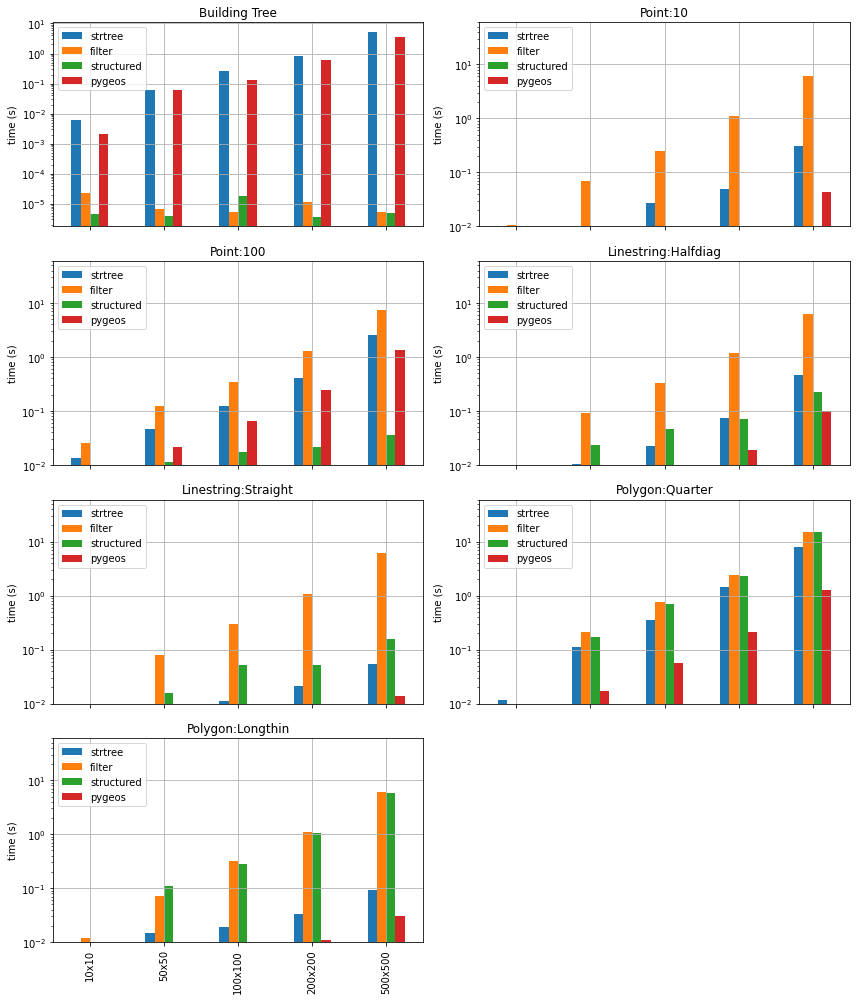

In [24]:
fig, axes = plt.subplots(int(np.ceil(len(cases)/2)), 2, figsize=(12, 14), sharex=True)
for i, c in enumerate(cases):
    ax = axes.ravel()[i]
    row = df.loc[[c]].stack()
    row.loc[c].plot.bar(ax=ax)
    ax.set_ylabel("time (s)")
    ax.set_title(c)
    ax.grid(visible=True)
    ax.set_yscale("log")
    if len(cases)%2 != 0:
        axes[-1, -1].set_visible(False)
    if i>0:
        ax.set_ylim(1e-2, 60)
fig.tight_layout()

How much faster is `X` than `Y`?

In [25]:
struct_df / strtree_df

,10x10,50x50,100x100,200x200,500x500
Building Tree,0.000731,0.000065,0.000068,0.000004,0.000001
Point:10,0.792365,0.48887,0.107536,0.088251,0.018631
Point:100,NaN,0.250542,0.139194,0.051876,0.014463
Linestring:Halfdiag,2.537968,2.183167,2.020972,0.974496,0.489805
Linestring:Straight,2.960316,2.248672,4.523994,2.393316,2.877007
Polygon:Quarter,0.719221,1.545687,1.961772,1.565511,1.900859
Polygon:Longthin,1.318367,7.334208,14.779888,31.933184,62.749413


In [26]:
strtree_df / pygeos_df

,10x10,50x50,100x100,200x200,500x500
Building Tree,2.859636,1.021219,1.940666,1.441979,1.545892
Point:10,13.698273,3.291287,7.050704,5.829301,7.100645
Point:100,5.798845,2.118838,1.876827,1.686815,1.835797
Linestring:Halfdiag,2.598924,2.102957,2.228777,3.909445,4.736566
Linestring:Straight,2.848213,2.55553,2.92461,3.099097,4.022425
Polygon:Quarter,6.430908,6.443166,6.240788,7.019544,6.210573
Polygon:Longthin,3.777643,8.036048,3.586074,3.085785,3.084189


In [28]:
import numpy as np
import pygeos

# array with pygeos geometries
arr =  ix2.rtree.geometries

# shape
geom = pygeos.io.from_wkb(shp.wkb)

In [29]:
# convert to chunked dask array
import dask.array
arr_dask = dask.array.from_array(ix2.rtree.geometries, chunks=50_000)

In [30]:
# %%timeit
# calculate single-threaded
res1 = pygeos.intersection(arr, geom)

In [31]:
def ix_area(icell, geom):
    return pygeos.area(pygeos.intersection(icell, geom))

In [33]:
import time

In [34]:
time_mean = []

for n in (1, 2, 3, 4, 6, 8):
    # define the operation
    arr_dask = dask.array.from_array(arr, chunks=int(len(arr) / n))
    res = arr_dask.map_blocks(pygeos.distance, geom, dtype=float)

    # run the benchmark 10 times
    times = []
    for _ in range(10):
        before = time.time()
        if n == 1:
            res.compute(scheduler="single-threaded", optimize_graph=False)
        else:
            res.compute(scheduler="threads", optimize_graph=False, num_workers=n)
        times.append(time.time() - before)

    time_mean.append(np.mean(times))

In [35]:
time_mean

[0.3379242420196533,
 0.17082784175872803,
 0.11625323295593262,
 0.09478495121002198,
 0.09290294647216797,
 0.08215615749359131]

In [36]:
# %%timeit
# threaded with dask
res2 = arr_dask.map_blocks(ix_area, geom, dtype=float)
a = res2.compute()

In [37]:
a0 = pygeos.area(res1)

In [38]:
pygeos.area(arr)

array([4., 4., 4., ..., 4., 4., 4.])

In [39]:
pygeos.area(res1[0])

2.0

In [40]:
a[a > 0]

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

In [41]:
ix2.rtree.query_bulk(geom, predicate="intersects")

array([[     0,      0,      0, ...,      0,      0,      0],
       [249500, 249501, 249000, ...,    501,      0,      1]])

In [42]:
# from pandas.util.testing
from functools import wraps

def test_parallel(num_threads=2, kwargs_list=None):
    """Decorator to run the same function multiple times in parallel.

    Parameters
    ----------
    num_threads : int, optional
        The number of times the function is run in parallel.
    kwargs_list : list of dicts, optional
        The list of kwargs to update original
        function kwargs on different threads.
    Notes
    -----
    This decorator does not pass the return value of the decorated function.

    Original from scikit-image:

    https://github.com/scikit-image/scikit-image/pull/1519

    """

    assert num_threads > 0
    has_kwargs_list = kwargs_list is not None
    if has_kwargs_list:
        assert len(kwargs_list) == num_threads
    import threading

    def wrapper(func):
        @wraps(func)
        def inner(*args, **kwargs):
            if has_kwargs_list:
                update_kwargs = lambda i: dict(kwargs, **kwargs_list[i])
            else:
                update_kwargs = lambda i: kwargs
            threads = []
            for i in range(num_threads):
                updated_kwargs = update_kwargs(i)
                thread = threading.Thread(target=func, args=args, kwargs=updated_kwargs)
                threads.append(thread)
            for thread in threads:
                thread.start()
            for thread in threads:
                thread.join()

        return inner

    return wrapper

In [43]:
arr = pygeos.polygons(np.random.rand(100_000, 4, 2))

# Running this 4 times sequentially:
def f():
    for i in range(6):
        pygeos.area(arr)

%timeit f()

# Running this 4 times but in parallel:
@test_parallel(6)
def g():
    pygeos.area(arr)

%timeit g()

46 ms ± 3.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
11.2 ms ± 951 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Testing performance with 900 shapes

In [44]:
from tqdm import tqdm

In [45]:
method = "vertex"
rtree = True

N = 100

df = pd.DataFrame(index=range(N), columns=["{0}x{0}".format(s) for s in [500]])

nrnc = 500
print("-"*10 + "{0}x{0}".format(nrnc) + "-"*10)

# build tree
sgr = get_structured_grid(nrnc)
t = %timeit -o -r 1 -n 1 GridIntersect(sgr, method="vertex", rtree=rtree)
print("Building Tree", "{0}x{0}".format(nrnc) + f" {t.average:.2f} seconds")

ix = GridIntersect(sgr, method=method, rtree=rtree)

results = []

shp = Polygon([(1, 1), (999, 999), (750, 1000), (2, 250), (1, 1)])

for i in tqdm(range(N)):
    results.append(ix.intersect(shp, sort_by_cellid=False))

#     df.loc[i, "{0}x{0}".format(nrnc)] = t.average

----------500x500----------


/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


5.58 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Building Tree 500x500 5.58 seconds


  8%|▊         | 8/100 [01:12<13:50,  9.03s/it]


KeyboardInterrupt: 

<AxesSubplot:>

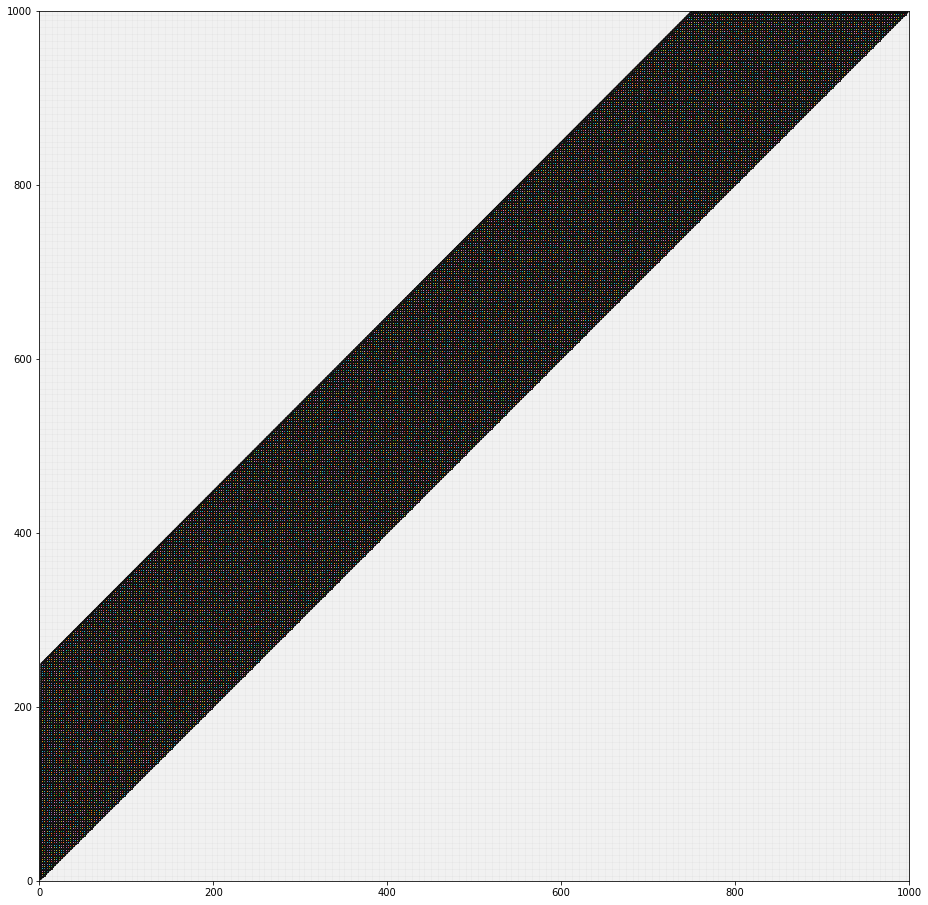

In [ ]:
fig, ax =plt.subplots(1, 1, figsize=(16, 16))
sgr.plot(ax=ax, lw=0.1)
ix.plot_polygon(results[0], ax=ax)

In [46]:
import geopandas as gpd

ix._vtx_grid_to_shape_list()

/home/david/anaconda3/envs/artesia/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


AttributeError: 'StructuredGrid' object has no attribute '_cell2d'

In [47]:
df = pd.DataFrame(index=range(sgr.nrow * sgr.ncol), columns=["geometry"], data=ix._rect_grid_to_shape_list())

/home/david/Github/flopy_db/examples/Notebooks/../../flopy/utils/gridintersect.py:301: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


In [48]:
griddf = gpd.GeoDataFrame(df)

In [49]:
shapes = gpd.GeoDataFrame(geometry=[shp]*1)

In [50]:
t = %timeit -o -r 1 -n 1 gpd.sjoin(shapes, griddf, how="left")

607 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [51]:
result = gpd.sjoin(shapes, griddf, how="left")

In [52]:
result

,geometry,index_right
0,"POLYGON ((1.000 1.000, 999.000 999.000, 750.00...",235529
0,"POLYGON ((1.000 1.000, 999.000 999.000, 750.00...",235030
0,"POLYGON ((1.000 1.000, 999.000 999.000, 750.00...",249500
0,"POLYGON ((1.000 1.000, 999.000 999.000, 750.00...",249501
0,"POLYGON ((1.000 1.000, 999.000 999.000, 750.00...",249000
...,...,...
0,"POLYGON ((1.000 1.000, 999.000 999.000, 750.00...",60753
0,"POLYGON ((1.000 1.000, 999.000 999.000, 750.00...",46782
0,"POLYGON ((1.000 1.000, 999.000 999.000, 750.00...",46781
0,"POLYGON ((1.000 1.000, 999.000 999.000, 750.00...",46282


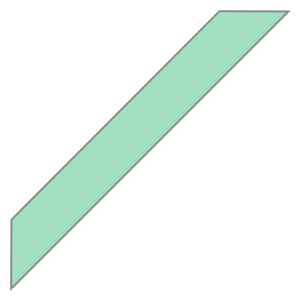

In [55]:
shp

(0.0, 100.0, 0.0, 100.0)

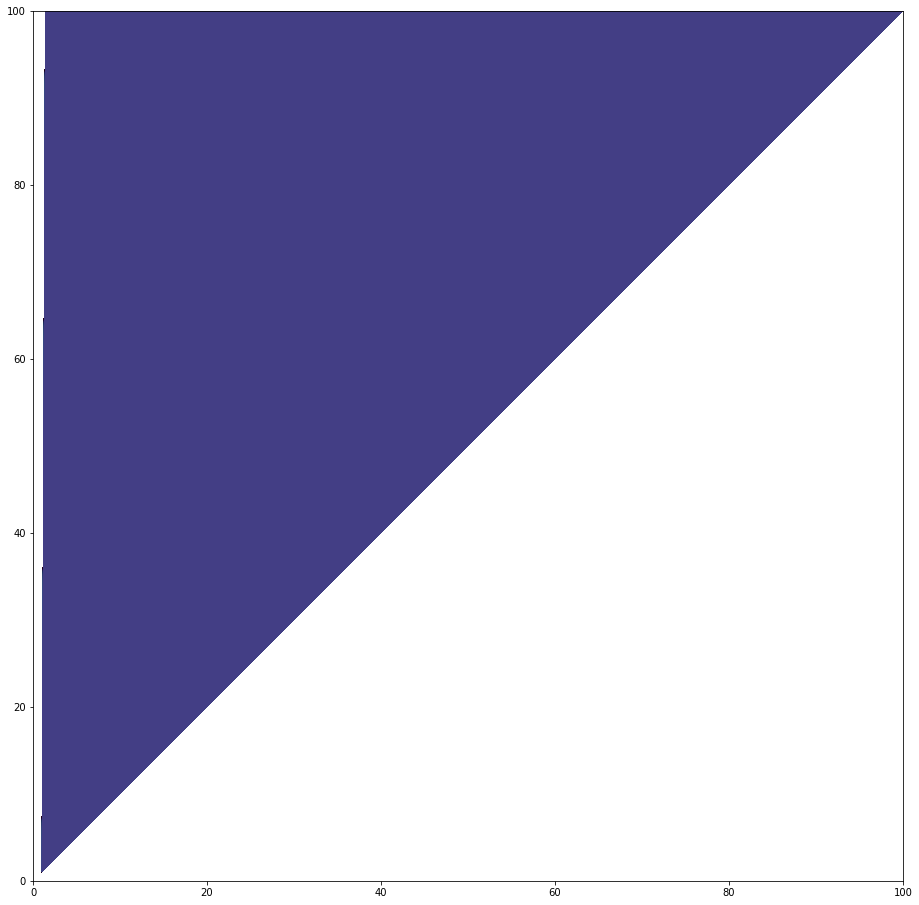

In [53]:
ax = result.plot(column="index_right", figsize=(16, 16))
ax.axis([0, 100, 0, 100])

In [54]:
gpd.options.use_pygeos

True